In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import Flowers102
from torchvision.transforms import v2
import matplotlib.pyplot as plt
import numpy as np
import random

In [2]:
# Workout actual mean and std of WHOLE dataset
transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True)
])

train_dataset = Flowers102(root='', split='train', transform=transform, download=True)
test_dataset = Flowers102(root='', split='test', transform=transform, download=True)
val_dataset = Flowers102(root='', split='val', transform=transform, download=True)
dataset = torch.utils.data.ConcatDataset([train_dataset, test_dataset, val_dataset])
print(len(dataset))

# R, G, B
channel_sum = torch.zeros(3)
channel_sum_squared = torch.zeros(3)
count = 0

for img, _ in dataset:
    channel_sum += torch.mean(img, dim=(1, 2))
    channel_sum_squared += torch.mean(img ** 2, dim=(1, 2))
    count += 1

mean = channel_sum / count
std = torch.sqrt(channel_sum_squared / count - mean ** 2)

print("Mean:", mean)
print("Std:", std)

100%|██████████| 344862509/344862509 [00:45<00:00, 7617252.91it/s] 


Extracting flowers-102/102flowers.tgz to flowers-102


100%|██████████| 502/502 [00:00<00:00, 1615917.58it/s]


100%|██████████| 14989/14989 [00:00<00:00, 16671552.02it/s]


8189
Mean: tensor([0.4355, 0.3777, 0.2879])
Std: tensor([0.2968, 0.2459, 0.2703])


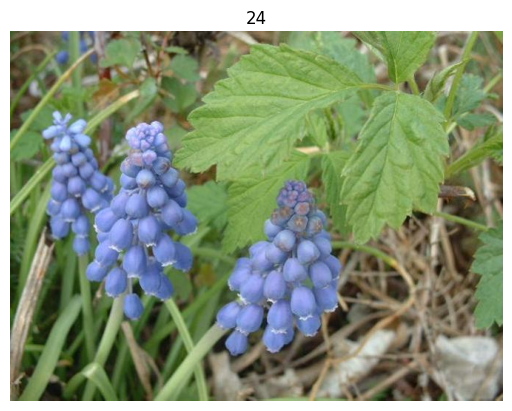

(500, 666, 3)


In [3]:
img, label = train_dataset[245]
np_img = img.permute(1, 2, 0).numpy()
plt.title(label)
plt.imshow((np_img * 255).astype('uint8'))
plt.axis('off')
plt.show()
print(np_img.shape)

In [4]:
train_transform = v2.Compose([
		 v2.ToImage(),
		 v2.RandomResizedCrop(size=(300,300), antialias=True),
		 v2.RandomRotation(30),
		 v2.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.2, hue=0.1),
		 v2.RandomAdjustSharpness(sharpness_factor=2),
		 v2.RandomPerspective(p=0.2), # looking at the images a lot of flowers are at diff perspectives
		 v2.ToDtype(torch.float32, scale=True),
		 v2.Normalize(mean=mean.numpy(), std=std.numpy()),
])

transform = v2.Compose([
		 v2.ToImage(),
		 v2.Resize((300,300)),
		 v2.ToDtype(torch.float32, scale=True),
		 v2.Normalize(mean=mean.numpy(), std=std.numpy()),
])

In [5]:
training_data = Flowers102( root='', split='train', transform=train_transform, download=False)
testing_data = Flowers102(root='',split='test',transform=transform,download=False)
evaluation_data = Flowers102(root='',split='val',transform=transform,download=False)

In [6]:
print('Training data has {} instances'.format(len(training_data)))
print('Evaluation data has {} instances'.format(len(evaluation_data)))
print('Testing data has {} instances'.format(len(testing_data)))

Training data has 1020 instances
Evaluation data has 1020 instances
Testing data has 6149 instances


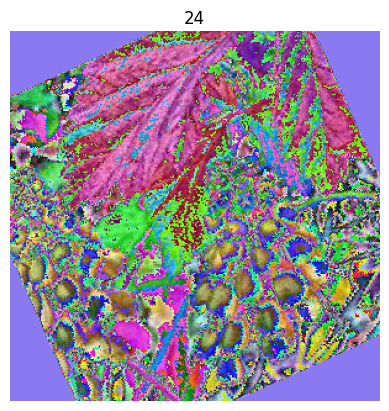

In [7]:
img, label = training_data[245] # just a random instance to see how the data has been normalised
np_img = img.permute(1, 2, 0).numpy()
plt.title(label)
plt.imshow((np_img * 255).astype('uint8'))
plt.axis('off')
plt.show()

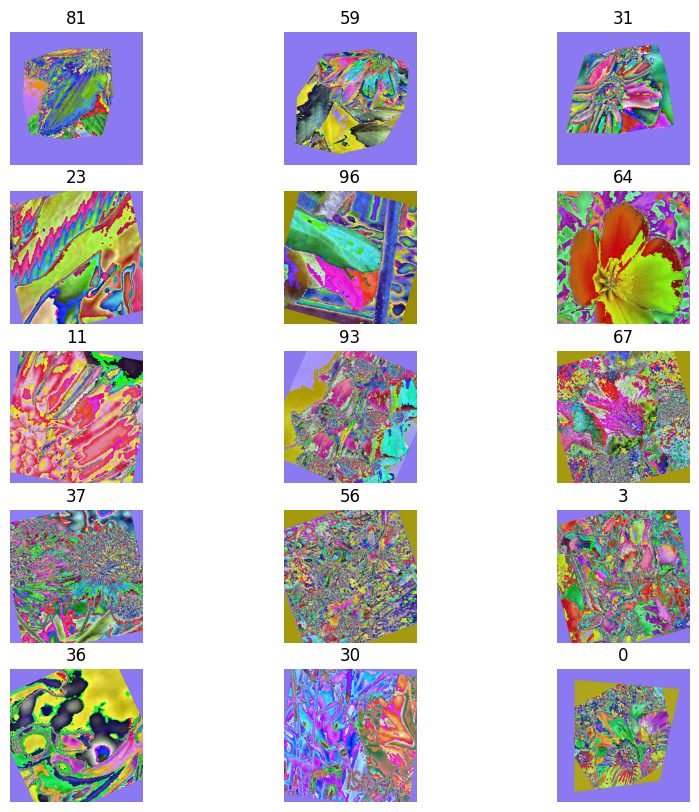

In [8]:
figure = plt.figure(figsize=(10, 10))
cols, rows = 3, 5
for i in range(1, cols * rows + 1):
	sample_idx = torch.randint(len(training_data), size=(1,)).item()
	img, label = training_data[sample_idx]

	np_img = img.permute(1, 2, 0).numpy()
	figure.add_subplot(rows, cols, i)
	plt.title(label)
	plt.imshow((np_img * 255).astype('uint8'))
	plt.axis('off')
plt.show()

In [9]:
# transform simple NN into a CNN
class FlowerClassifier(nn.Module):
	def __init__(self):
			super(FlowerClassifier, self).__init__()
			self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
			#self.bn1 = nn.BatchNorm2d(16)
			self.conv2 = nn.Conv2d(32, 32, kernel_size=3)
			#self.bn2 = nn.BatchNorm2d(32)
			self.conv3 = nn.Conv2d(32, 64, kernel_size=3)
			#self.bn3 = nn.BatchNorm2d(64)
			self.conv4 = nn.Conv2d(64, 64, kernel_size=3)
			#self.bn4 = nn.BatchNorm2d(128)
			self.pool = nn.MaxPool2d(2, 2)
			self.flatten = nn.Flatten()
			self.fc1 = nn.Linear(64 * 72 * 72, 300)
			self.fc2 = nn.Linear(300,102)

	def forward(self, x):
		x = F.relu(self.conv1(x))
		x = F.relu(self.conv2(x))
		x = self.pool(x)
		x = F.relu(self.conv3(x))
		x = F.relu(self.conv4(x))
		x = self.pool(x)
		x = self.flatten(x)
		x = self.fc1(x)
		x = self.fc2(x)
		return F.log_softmax(x, dim=1)

In [10]:
# Check if CUDA is available
if torch.cuda.is_available():
	print("CUDA is available!")
	device = torch.device("cuda")
else:
	print("CUDA is not available. The model will use CPU.")
	device = torch.device("cpu")

CUDA is available!


In [11]:
def plot_graphs(train_losses, eval_losses, eval_accuracies):
    # Plotting the training and evaluation losses
    plt.figure(figsize=(8, 4))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
    plt.plot(range(1, len(eval_losses) + 1), eval_losses, label='Evaluation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Evaluation Losses')
    plt.legend()
    plt.show()

    # Plotting the evaluation accuracy
    plt.figure(figsize=(8, 4))
    plt.plot(range(1, len(eval_accuracies) + 1), eval_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy')
    plt.legend()
    plt.show()

In [12]:
def train(model, training_loader, evaluation_loader, criterion, optimizer, patience=5, epochs=10):
	train_losses = []
	eval_losses = []
	eval_accuracies = []

	best_valid_loss = np.inf
	patience_counter = 0

	for epoch in range(epochs):
		model.train()
		training_loss = 0.0
		for inputs, labels in training_loader:
			inputs, labels = inputs.to(device), labels.to(device)
			optimizer.zero_grad()
			outputs = model(inputs)
			loss = criterion(outputs, labels)
			loss.backward()
			optimizer.step()
			training_loss += loss.item() * inputs.size(0)

		training_loss /= len(training_loader.dataset)
		train_losses.append(training_loss)

		model.eval()
		evaluation_loss = 0.0
		correct = 0
		total = 0
		with torch.no_grad():
			for inputs, labels in evaluation_loader:
				inputs, labels = inputs.to(device), labels.to(device)
				outputs = model(inputs)
				loss = criterion(outputs, labels)
				evaluation_loss += loss.item() * inputs.size(0)
				_, predicted = torch.max(outputs, 1)
				total += labels.size(0)
				correct += (predicted == labels).sum().item()

		evaluation_loss /= len(evaluation_loader.dataset)
		evaluation_accuracy = correct / total
		eval_losses.append(evaluation_loss)
		eval_accuracies.append(evaluation_accuracy)

		print(
			f'Epoch {epoch + 1}/{epochs}, Training Loss: {training_loss:.4f}, Evaluation Loss: {evaluation_loss:.4f}, Val Accuracy: {evaluation_accuracy:.4f}')

		if evaluation_loss < best_valid_loss:
				best_valid_loss = evaluation_loss
				patience_counter = 0
		else:
				patience_counter += 1
				if patience_counter >= patience:
						print(f'Validation loss did not improve for {patience} epochs. Early stopping...')
						break

	print('Training finished.')
	plot_graphs(train_losses, eval_losses, eval_accuracies)

In [13]:
training_loader = DataLoader(training_data, batch_size=128, shuffle=True)
evaluation_loader = DataLoader(evaluation_data, batch_size=128, shuffle=False)

Epoch 1/100, Training Loss: 4.7666, Evaluation Loss: 4.5718, Val Accuracy: 0.0216
Epoch 2/100, Training Loss: 4.5386, Evaluation Loss: 4.4027, Val Accuracy: 0.0480
Epoch 3/100, Training Loss: 4.3547, Evaluation Loss: 4.1589, Val Accuracy: 0.0725
Epoch 4/100, Training Loss: 4.1574, Evaluation Loss: 3.9861, Val Accuracy: 0.0902
Epoch 5/100, Training Loss: 4.0472, Evaluation Loss: 3.8567, Val Accuracy: 0.1382
Epoch 6/100, Training Loss: 3.9039, Evaluation Loss: 3.7343, Val Accuracy: 0.1490
Epoch 7/100, Training Loss: 3.8538, Evaluation Loss: 3.6583, Val Accuracy: 0.1569
Epoch 8/100, Training Loss: 3.7086, Evaluation Loss: 3.5799, Val Accuracy: 0.1784
Epoch 9/100, Training Loss: 3.6833, Evaluation Loss: 3.4987, Val Accuracy: 0.1814
Epoch 10/100, Training Loss: 3.5793, Evaluation Loss: 3.4537, Val Accuracy: 0.1941
Epoch 11/100, Training Loss: 3.5220, Evaluation Loss: 3.3885, Val Accuracy: 0.1863
Epoch 12/100, Training Loss: 3.4872, Evaluation Loss: 3.3498, Val Accuracy: 0.1941
Epoch 13/100,

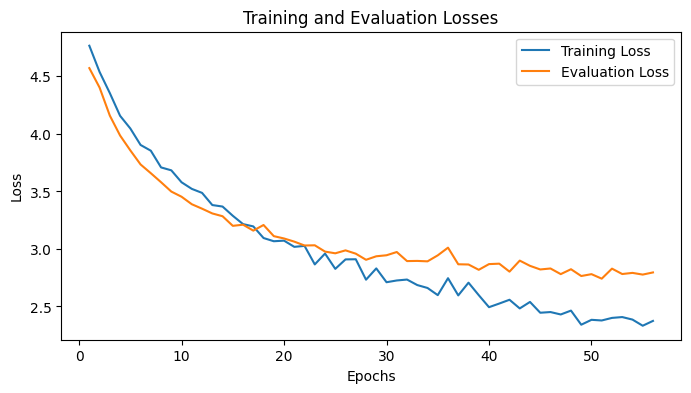

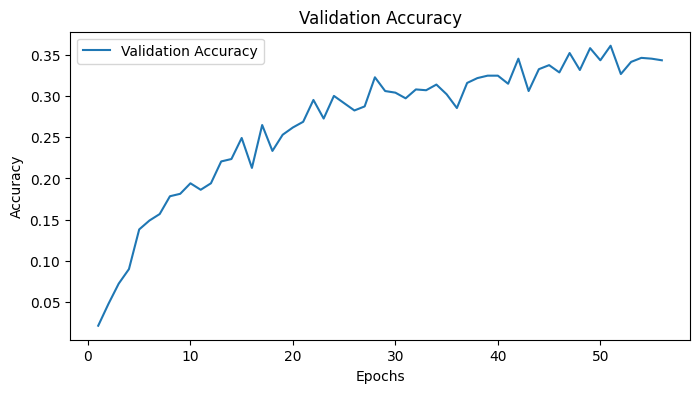

In [14]:
model = FlowerClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

train(model, training_loader, evaluation_loader, criterion, optimizer, epochs=100)

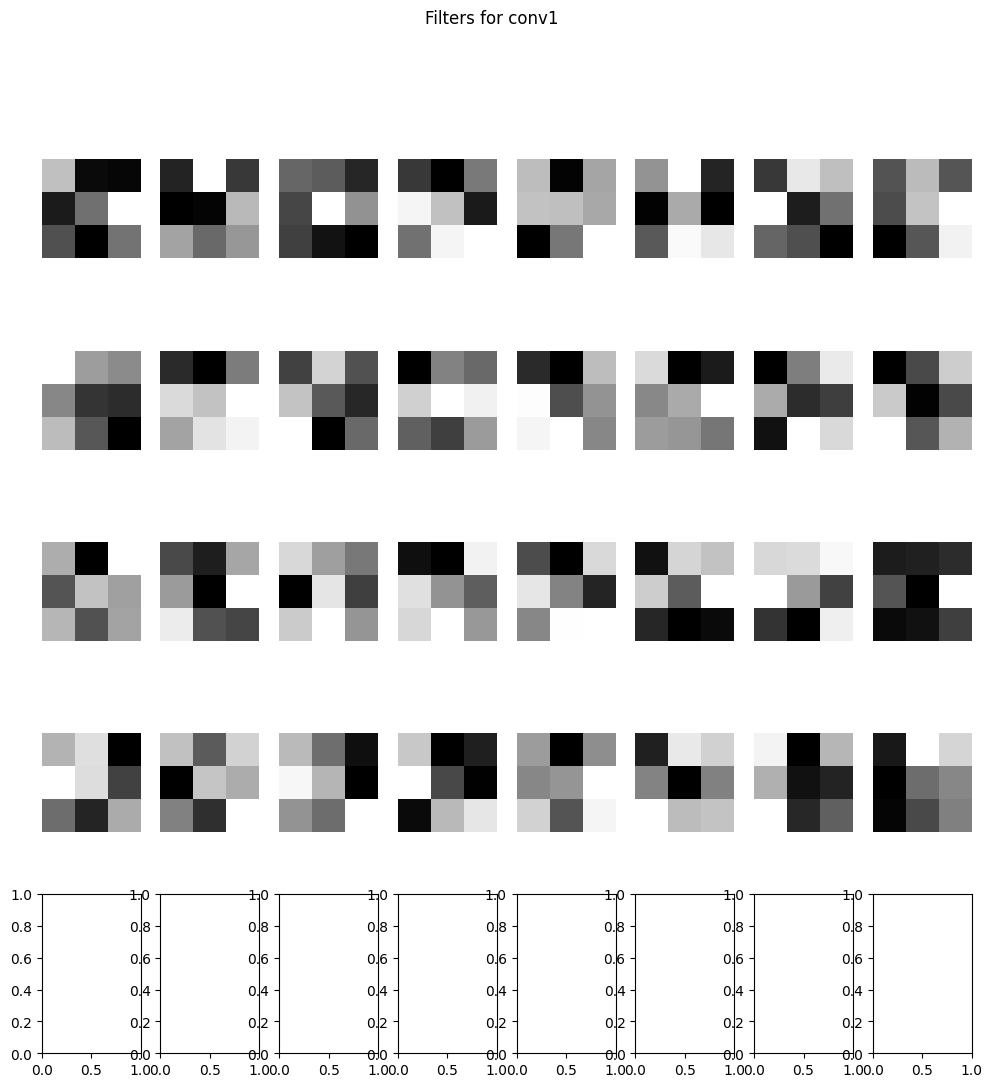

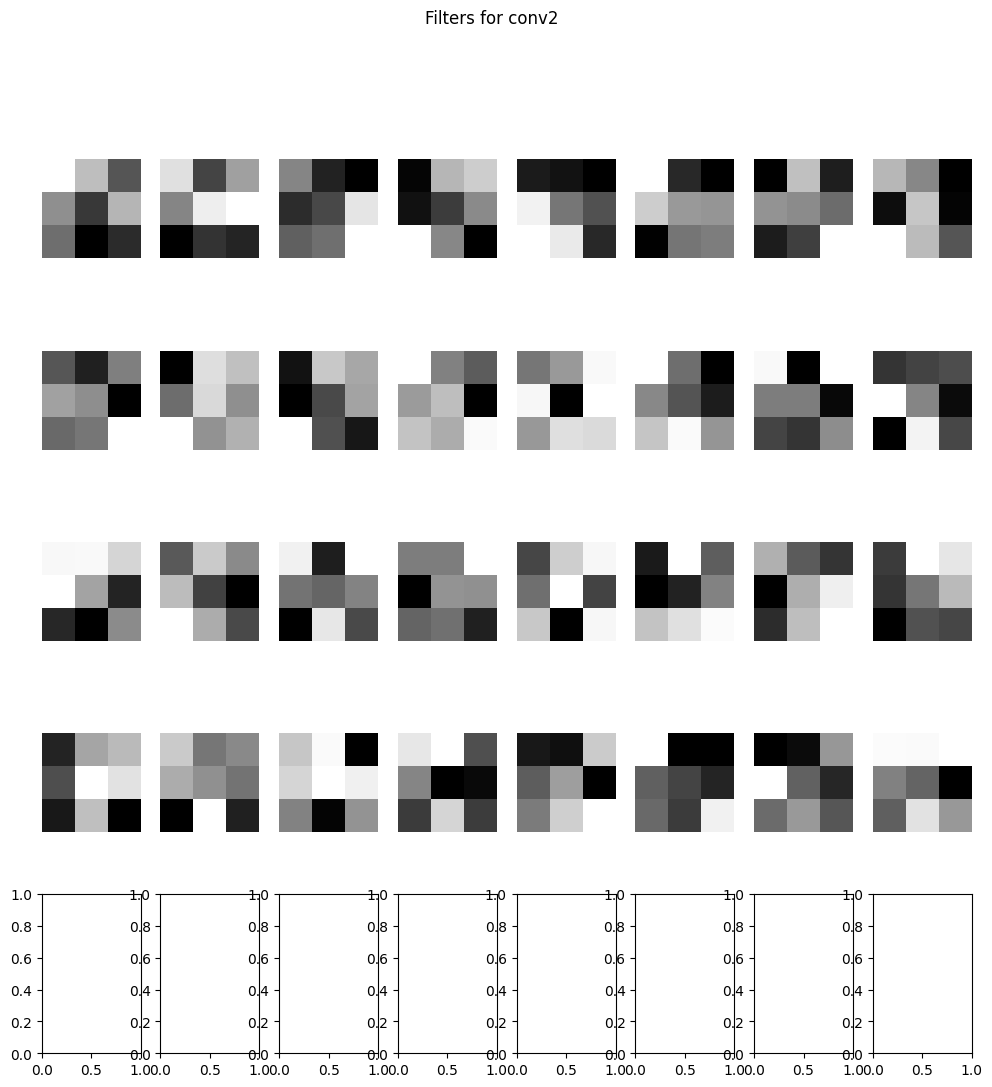

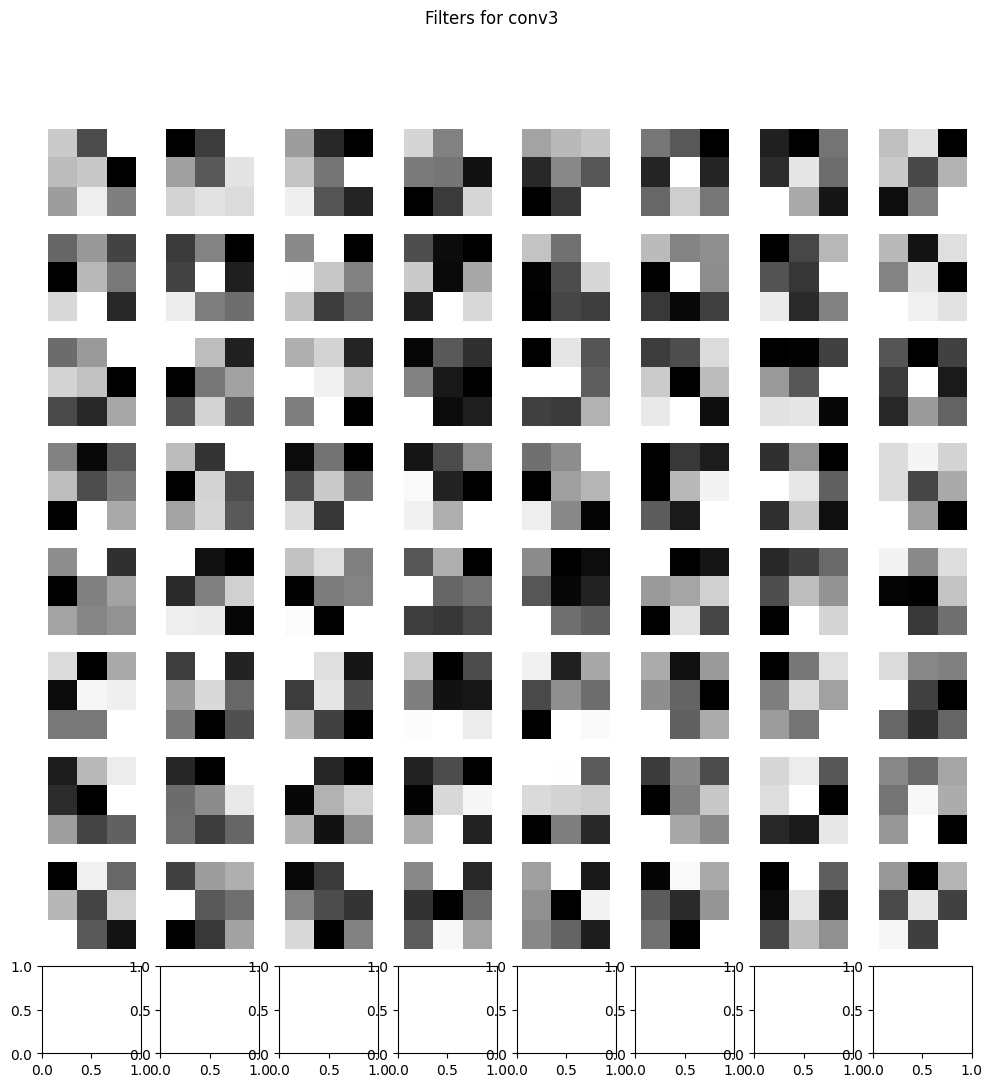

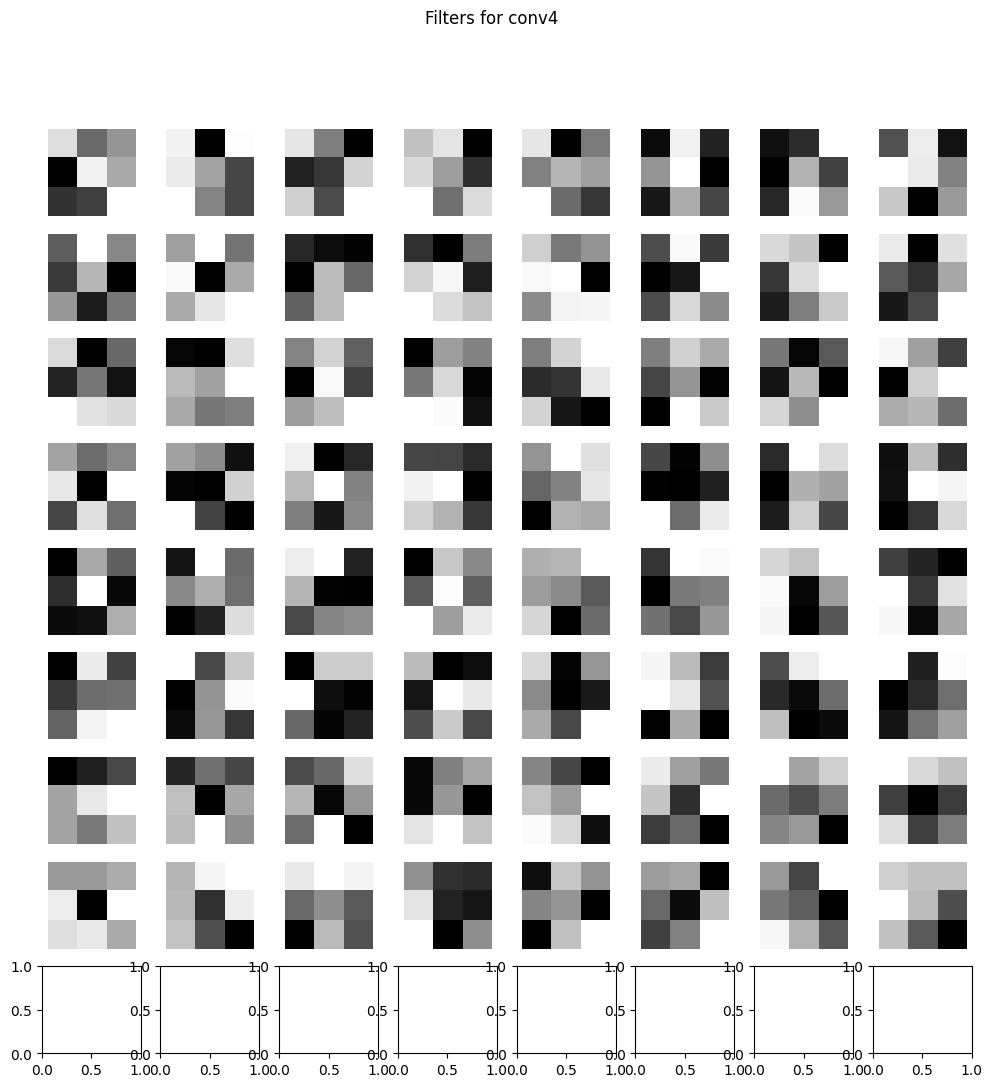

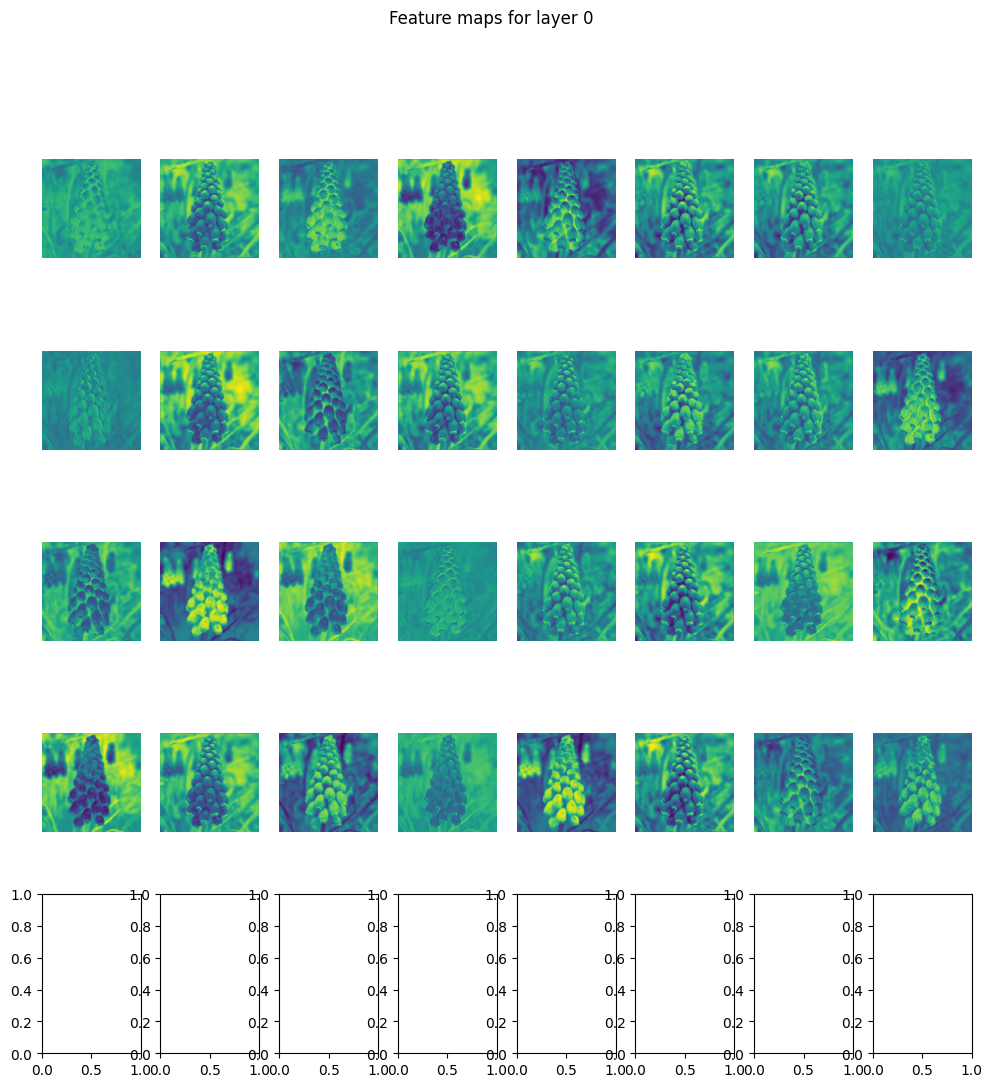

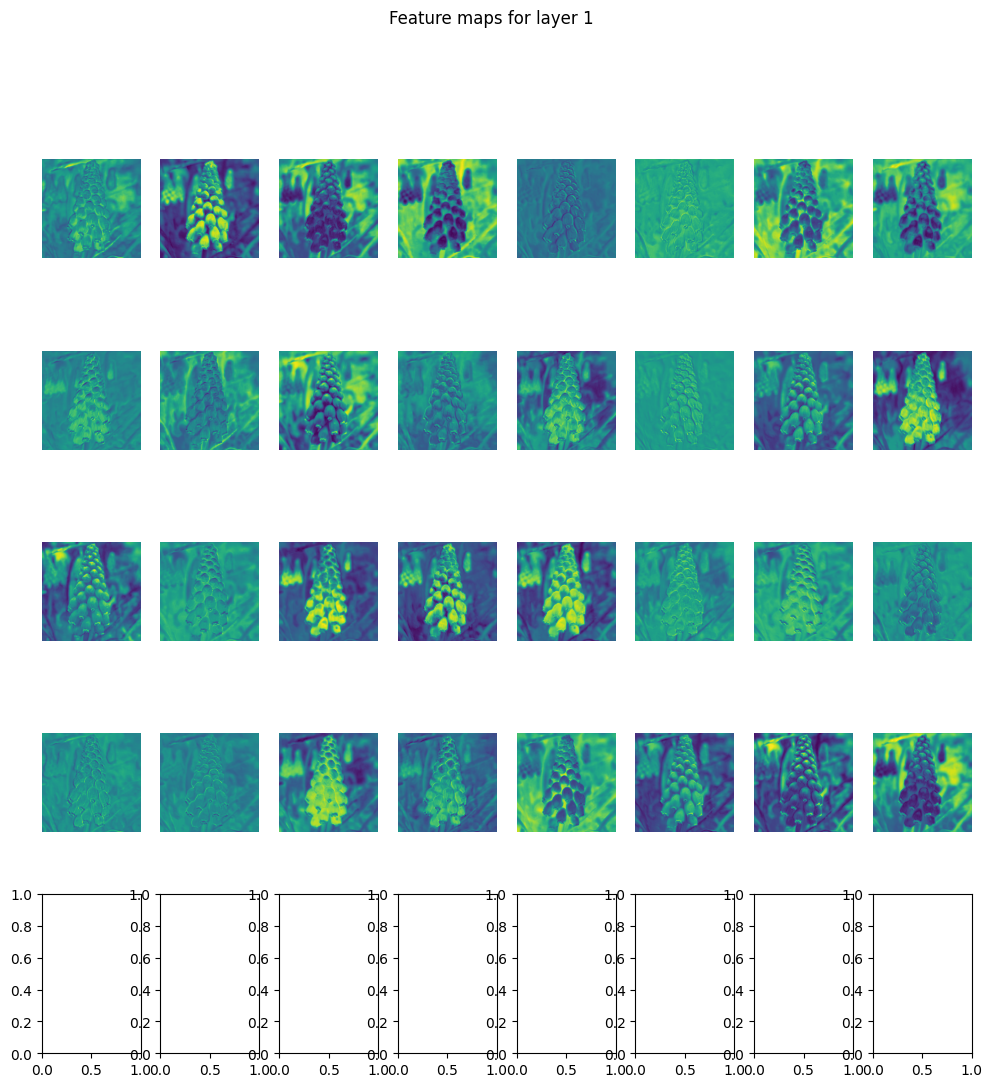

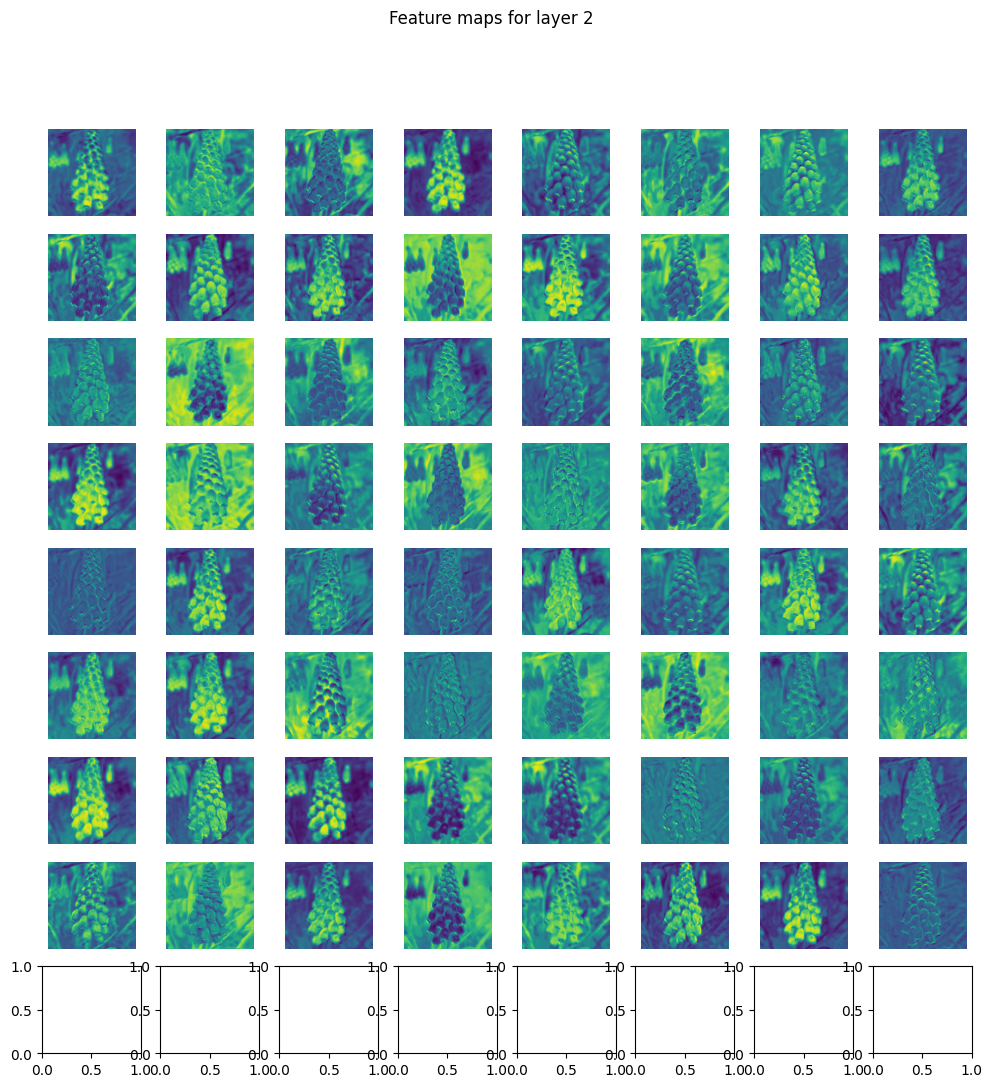

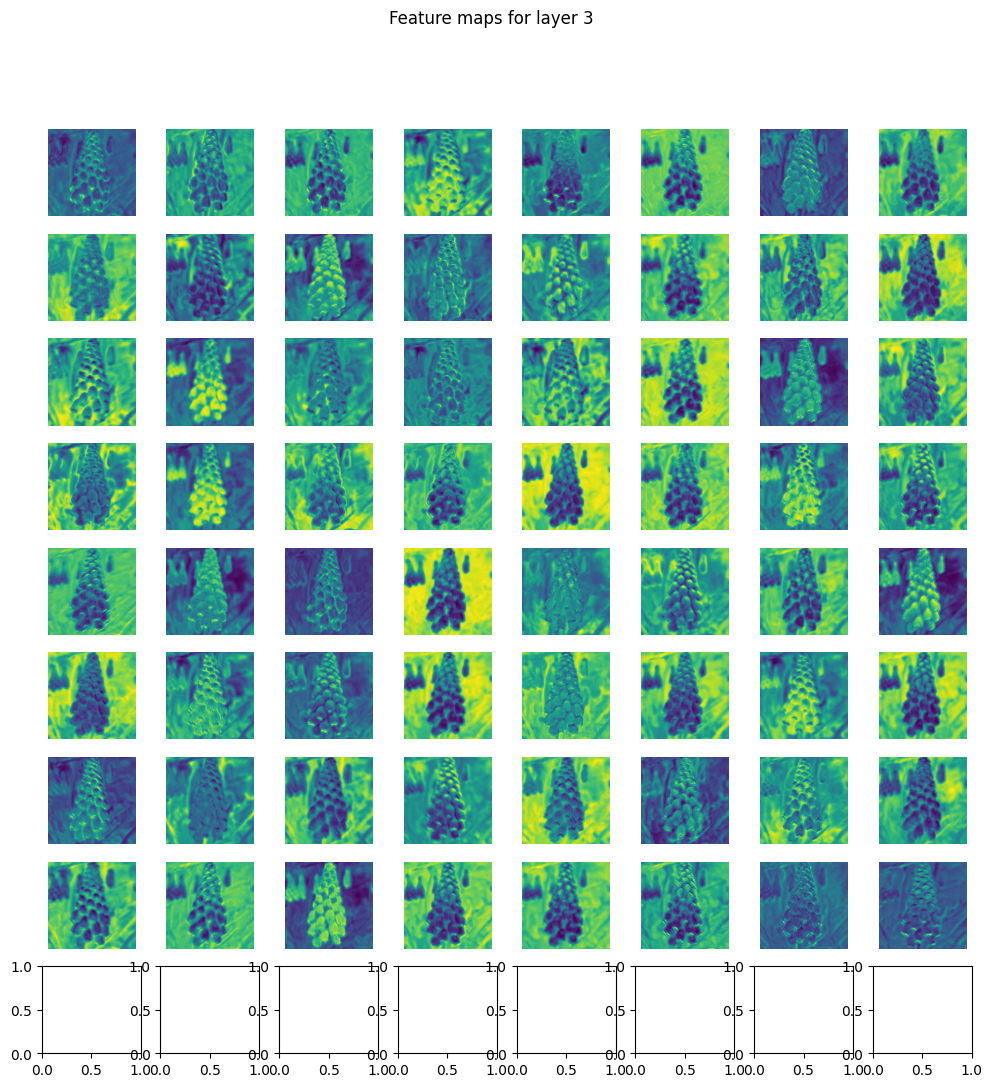

In [15]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Define a function to visualize filters
def visualize_filters(model, device):
    for name, module in model.named_modules():
        if isinstance(module, nn.Conv2d):
            filters = module.weight.data.to('cpu').numpy()
            num_filters = filters.shape[0]
            num_cols = min(8, num_filters)
            num_rows = (num_filters // num_cols) + 1
            fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 12))
            fig.suptitle(f'Filters for {name}')
            for i in range(num_filters):
                ax = axs[i // num_cols, i % num_cols]
                ax.imshow(filters[i, 0], cmap='gray')
                ax.axis('off')
            plt.show()

# Define a function to visualize feature maps
def visualize_feature_maps(model, input_image, device):
    activations = []
    def hook(module, input, output):
        activations.append(output)
    handles = []
    for name, module in model.named_modules():
        if isinstance(module, nn.Conv2d):
            handle = module.register_forward_hook(hook)
            handles.append(handle)
    with torch.no_grad():
        _ = model(input_image.unsqueeze(0).to(device))
    for handle in handles:
        handle.remove()
    for i, activation_map in enumerate(activations):
        num_features = activation_map.size(1)
        num_cols = min(8, num_features)
        num_rows = (num_features // num_cols) + 1
        fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 12))
        fig.suptitle(f'Feature maps for layer {i}')
        for j in range(num_features):
            ax = axs[j // num_cols, j % num_cols]
            ax.imshow(activation_map[0, j].to('cpu'), cmap='viridis')
            ax.axis('off')
        plt.show()


img, label = evaluation_data[245] # Random image

visualize_filters(model, device)
visualize_feature_maps(model, img, device)

Evaluation Loss: 2.7957, Accuracy: 0.3431
There were 670 images predicted incorrectly by the model.


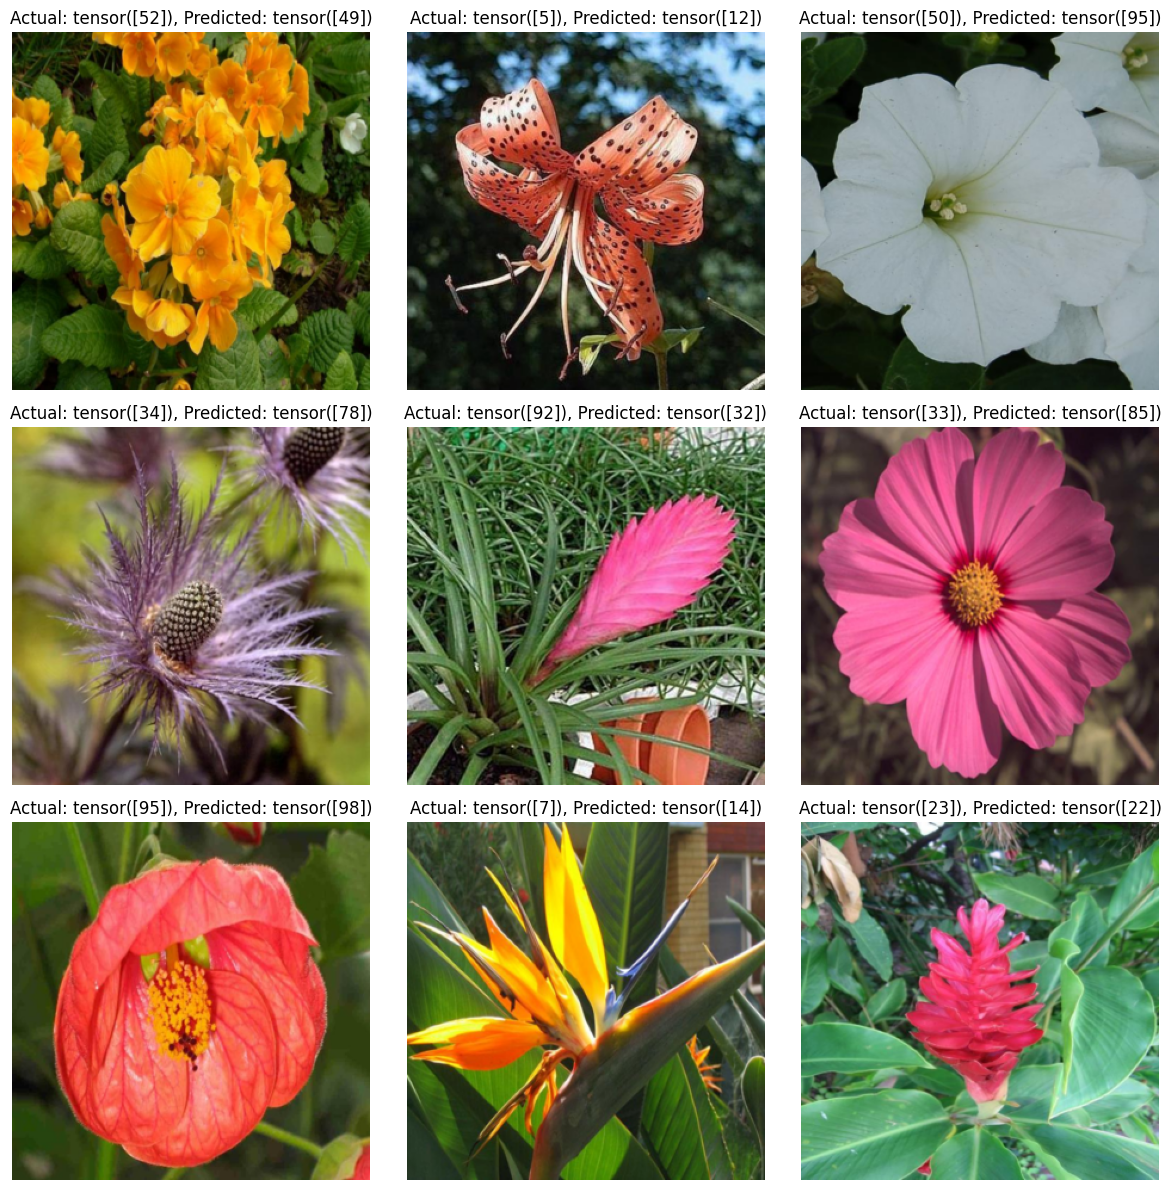

In [16]:
def evaluate(model, evaluation_loader, criterion):
    model.eval()
    evaluation_loss = 0.0
    correct = 0
    total = 0
    misclassified_images = []

    with torch.no_grad():
        for inputs, labels in evaluation_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            evaluation_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            misclassified_inds = (predicted != labels).nonzero()
            for mis_ind in misclassified_inds:
                mis_img = inputs[mis_ind].cpu()
                mis_label = labels[mis_ind].cpu()
                mis_pred = predicted[mis_ind].cpu()
                misclassified_images.append((mis_img, mis_label, mis_pred))

    evaluation_loss /= len(evaluation_loader.dataset)
    evaluation_accuracy = correct / total

    print(f'Evaluation Loss: {evaluation_loss:.4f}, Accuracy: {evaluation_accuracy:.4f}')

    return misclassified_images

misclassified_images = evaluate(model, evaluation_loader, criterion)
print(f'There were {len(misclassified_images)} images predicted incorrectly by the model.')

# Plot random misclassified images
figure = plt.figure(figsize=(12, 12))
cols, rows = 3, 3
selected_indices = random.sample(range(len(misclassified_images)), min(cols * rows, len(misclassified_images)))
for i, index in enumerate(selected_indices, 1):
    mis_img, mis_label, mis_pred = misclassified_images[index]
    np_img = (mis_img.squeeze().permute(1, 2, 0).numpy() * std.numpy() + mean.numpy()).clip(0, 1)
    figure.add_subplot(rows, cols, i)
    plt.title(f'Actual: {mis_label}, Predicted: {mis_pred}')
    plt.imshow((np_img * 255).astype('uint8'))
    plt.axis('off')

plt.tight_layout()
plt.show()

In [17]:
def list_misclassification_examples_per_class(misclassified_images, num_examples=1):
    classes_dict = {}
    total_misclassified = 0

    for _, true_label, pred_label in misclassified_images:
        true_label = true_label.item()
        pred_label = pred_label.item()
        if true_label not in classes_dict:
            classes_dict[true_label] = {"count": 0, "examples": []}
        if classes_dict[true_label]["count"] < num_examples:
            classes_dict[true_label]["examples"].append(pred_label)
        classes_dict[true_label]["count"] += 1
        total_misclassified += 1

    for true_label, misclassified_info in classes_dict.items():
        print(f"True Label: {true_label}, Misclassified Count: {misclassified_info['count']}")

    print(f"Total Misclassified Images: {total_misclassified}")

# Assuming num_classes is defined and represents the total number of classes
num_classes = 102  # Adjust this according to your dataset

# List misclassification examples per class
list_misclassification_examples_per_class(misclassified_images)

True Label: 0, Misclassified Count: 6
True Label: 1, Misclassified Count: 1
True Label: 2, Misclassified Count: 10
True Label: 3, Misclassified Count: 10
True Label: 4, Misclassified Count: 10
True Label: 5, Misclassified Count: 7
True Label: 6, Misclassified Count: 4
True Label: 7, Misclassified Count: 6
True Label: 8, Misclassified Count: 7
True Label: 9, Misclassified Count: 2
True Label: 10, Misclassified Count: 10
True Label: 11, Misclassified Count: 7
True Label: 12, Misclassified Count: 4
True Label: 13, Misclassified Count: 5
True Label: 14, Misclassified Count: 3
True Label: 15, Misclassified Count: 7
True Label: 20, Misclassified Count: 5
True Label: 16, Misclassified Count: 4
True Label: 17, Misclassified Count: 9
True Label: 18, Misclassified Count: 8
True Label: 19, Misclassified Count: 6
True Label: 21, Misclassified Count: 2
True Label: 22, Misclassified Count: 8
True Label: 23, Misclassified Count: 8
True Label: 24, Misclassified Count: 8
True Label: 25, Misclassified C